In [1]:
#!pip install pandas --upgrade  --quiet
#!pip install numpy --upgrade  --quiet
#!pip install scipy --upgrade  --quiet
#!pip install statsmodels --upgrade  --quiet
#!pip install scikit-learn --upgrade  --quiet
#!pip install missingno --upgrade  --quiet
#!pip install torch --upgrade --quiet
!pip install apafib --upgrade --quiet

Objetivos de aprendizaje:
1. Conocer el análisis de problemas usando máquinas de soporte vectorial, árboles
de decisión y conjuntos de clasificadores
2. Interpretar modelos de árboles de decisión
3. Usar técnicas de relevancia de atributos sobre clasificadores no lineales

# Problema 1
El centro de investigaciones sociológicas (CIS) es un organismo que tiene por finalidad el estudio científico de la sociedad y es una gran fuente de datos. Entre los diferentes estudios que se realizaron durante este año hubo uno sobre la percepción de la sociedad de la inteligencia artificial preguntando sobre su conocimiento sobre el tema, sus efectos y consecuencias en la
sociedad y en el mercado de trabajo y en los dilemas éticos que supone. La clave de las variables y su significado la puedes encontrar en la página web de los problemas. 

Los datos se pueden obtener de la libreria `apafib` mediante `load_CIS_IA`. 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import warnings
import logging
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report, 
                             RocCurveDisplay, PrecisionRecallDisplay,
                             accuracy_score, f1_score, precision_score, recall_score)
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import label_binarize, OneHotEncoder, StandardScaler
from sklearn.svm import SVC, LinearSVC
from skopt import BayesSearchCV
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier.rocauc import roc_auc
from IPython.display import display, HTML

show_html = lambda html: display(HTML(html))
np.int = int 

niter = 50
cv = 10

set_config(display='text')
warnings.filterwarnings('ignore')
logging.getLogger('matplotlib.font_manager').disabled = True
plt.rcParams.update({'font.size': 16})
pd.set_option('display.precision', 3)

In [3]:
def save_results(clf, X_test, y_test, nclf, df):
    df.loc[nclf,'train XV acc'] = clf.best_score_
    df.loc[nclf,'test acc'] = accuracy_score(y_test, clf.predict(X_test))
    df.loc[nclf,'precision score (M)'] = precision_score(y_test, clf.predict(X_test), average='macro')
    df.loc[nclf,'recall score (M)'] = recall_score(y_test, clf.predict(X_test), average='macro')
    df.loc[nclf,'f1 score (M)'] = f1_score(y_test, clf.predict(X_test), average='macro')
    return df

results_df = pd.DataFrame()

## Apartat a)
 - Dividir el conjunt de dades en (80%/20%)
 - Preprocessar les dades (imputació de valors perduts, codificació de variables, etc.)
 - Aplicar PCA en 2D
 - Podrien ser les classes linalment separables?

In [4]:
from apafib import load_CIS_IA
# Carreguem dataset
cis_ia = load_CIS_IA()
cis_ia.head()

X = cis_ia.drop(columns=['Class'])
y = cis_ia['Class']

### Exploració inicial

Abans de començar amb el processament del dataset, estaria bé fer una exploració inicial per veure quines característiques te les dades

In [5]:
print(cis_ia.info())
print("\nDistribucio de clases:")
print(y.value_counts())
print("\nPercentatge de clases:")
print(y.value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
Index: 1500 entries, 382 to 824
Data columns (total 74 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   SEXO      1500 non-null   category
 1   EDAD      1500 non-null   int64   
 2   P1        1493 non-null   category
 3   P2_1      1494 non-null   category
 4   P3_1      1498 non-null   float64 
 5   P3_2      1493 non-null   float64 
 6   P3_3      1489 non-null   float64 
 7   P3_4      1492 non-null   float64 
 8   P3_5      1496 non-null   float64 
 9   P3_6      1497 non-null   float64 
 10  P3_7      1485 non-null   float64 
 11  P3_8      1488 non-null   float64 
 12  P3_9      1490 non-null   float64 
 13  P3_10     1495 non-null   float64 
 14  P3_11     1492 non-null   float64 
 15  P3_12     1487 non-null   float64 
 16  P4        1496 non-null   category
 17  P5        1498 non-null   category
 18  P6        1498 non-null   category
 19  P7_1      1491 non-null   category
 20  P7_2      14

Veiem que una gran part de les variables són categòriques, i que hi ha un desbalanceig important entre les classes, ja que més del 56% de les mostres pertanyen a la classe 0, mentre que només un 10% de les mostres pertanyen a la classe 2. Aquest desbalanceig pot afectar al accuracy dels models (sobretot classe 2).

Pel que fa als valors nuls, veiem que la majoria de variables tenen valors nuls, però això ho avaluarem una mica més tard.


### Dividir el conjunt

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(X_train.shape)
print(X_test.shape)

(1200, 73)
(300, 73)


### Preprocessament

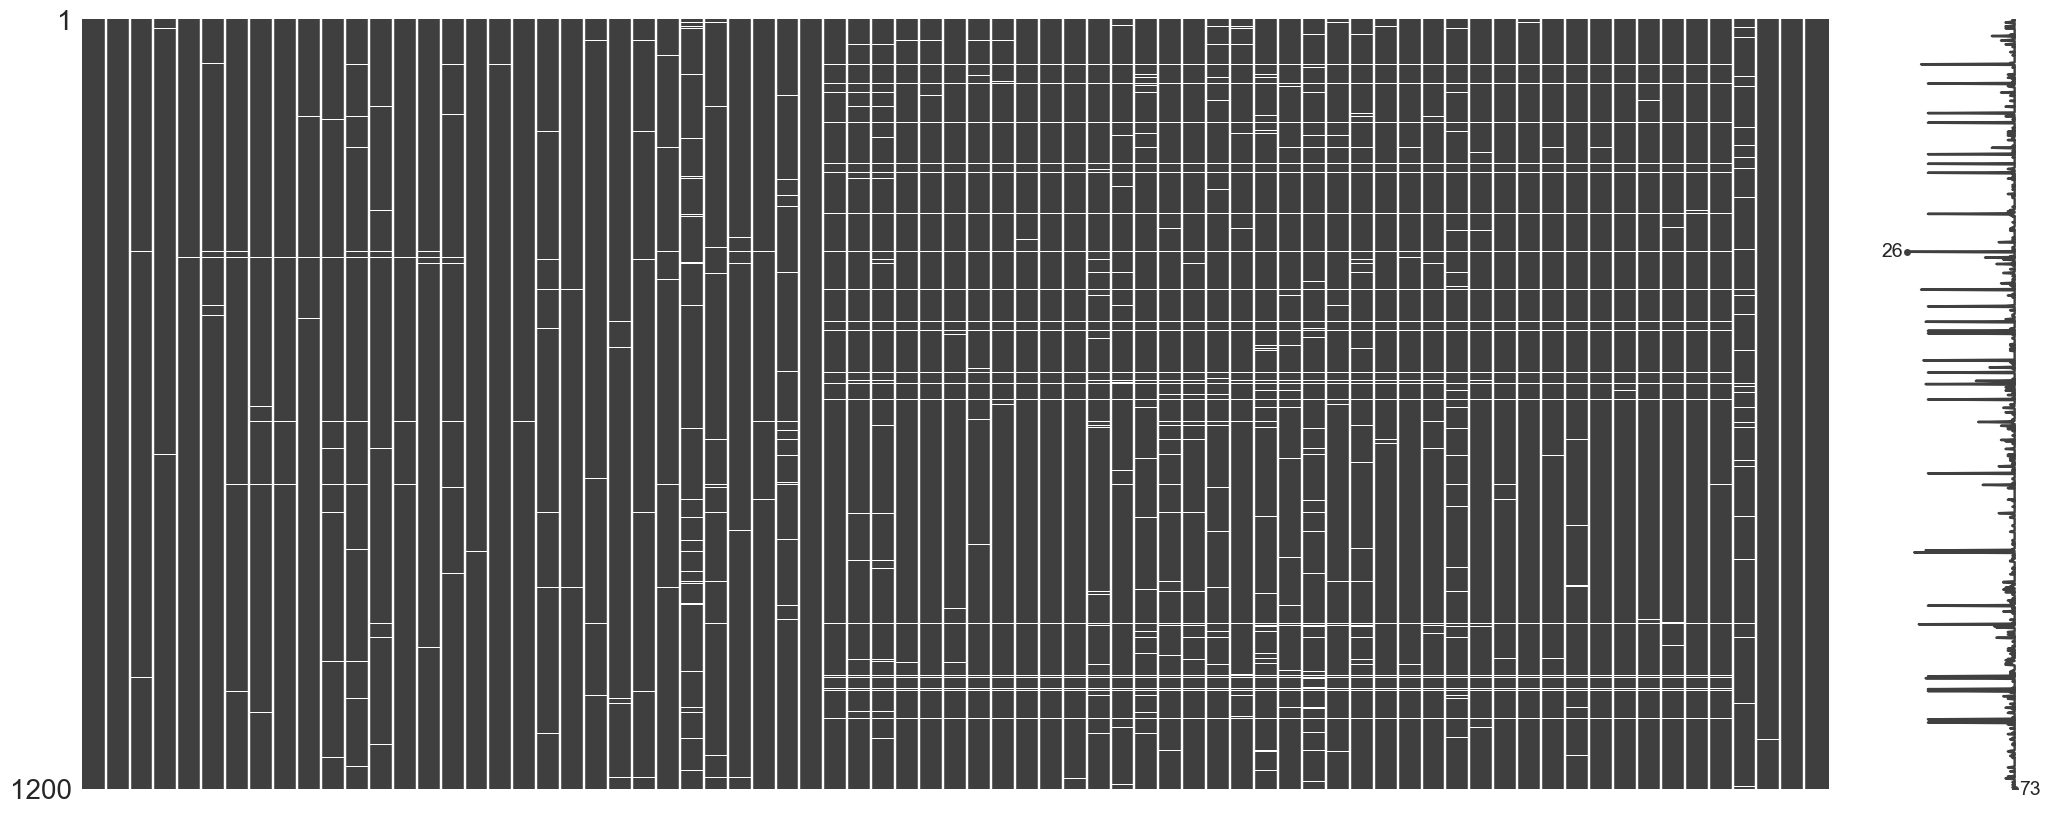

Nombre de variables amb valors nuls en l'entrenament: 68
Total de valors nuls en l'entrenament: 1810


In [7]:
msno.matrix(X_train)
plt.show()

varnnulls = varnnulls = X_train.isna().sum()[X_train.isna().sum() > 0]
print("Nombre de variables amb valors nuls en l'entrenament:", len(varnnulls))
print("Total de valors nuls en l'entrenament:", X_train.isna().sum().sum())


Veiem a simple vista que hi ha moltes variables amb valors nuls, en total hi ha un total de 1810 valors nuls (en train) dividits en 68 variables diferents. Així que caldrà fer una bona imputació dels valors nuls. Però, agafant la part bona, estan bastant repartits, és a dir, no hi ha cap variable que tingui gran part o la majoria de valors nuls.

Abans de començar amb el preprocessament, és necessari saber quines variables són categòriques i quines són numèriques, ja que cadascuna té un preprocessament diferent.

In [8]:
cat_cols = X.select_dtypes(include=['object', 'category']).columns
num_cols = X.select_dtypes(include=['number']).columns

print(f"Numèriques: {len(num_cols)}, Categòriques: {len(cat_cols)}")


Numèriques: 17, Categòriques: 56


Començarem amb el preprocessament de les variables categòriques. Els valors perduts els imputarem amb la moda de la variable i farem un one-hot encoding per transformar-les en variables numèriques. Aprofitarem per fer un pipeline per fer-ho.

In [9]:
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


Ara farem el preprocessament de les variables numèriques. Els valors perduts els imputarem amb $KNNImputer$ i estandarditzarem les variables. També farem un pipeline.

In [10]:
num_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler()) 
])

Ja que ja tenim els dos pipelines fets, ara farem un `ColumnTransformer` per aplicar cada pipeline a les variables corresponents. També ho aplicarem al conjunt d'entrenament i test.

In [11]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ])

X_train_pre = preprocessor.fit_transform(X_train)
X_test_pre = preprocessor.transform(X_test)

X_train_pre = X_train_pre.toarray()
X_test_pre = X_test_pre.toarray()

### PCA

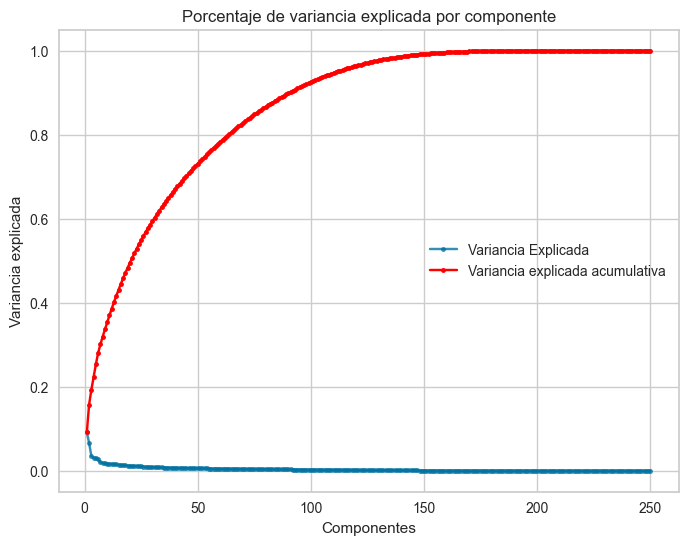

In [12]:
pca = PCA().fit(X_train_pre)

fig = plt.figure(figsize=(8,6))
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),pca.explained_variance_ratio_ ,alpha=0.8,marker='.',label="Variancia Explicada")
y_label = plt.ylabel('Variancia explicada')
x_label = plt.xlabel('Componentes')
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_),
         c='red',marker='.',
         label="Variancia explicada acumulativa")
plt.legend()
plt.title('Porcentaje de variancia explicada por componente');


Veiem que n'hi ha un munt de components i la majoria aporten molt poca informació, ja que amb aproximadament 50, ja tenim gairebé el 70% de la variancia explicada. Podem observar també que les primeres componentes aporten relativament més que les últimes, el que vol dir que la informació està **molt distribuida** entre les variables. Anem a veure quan explicen les dues primeres components.

In [13]:
print(f"PC1 + PC2: {np.sum(pca.explained_variance_ratio_[:2]):.2%}")
print(f"PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"PC2: {pca.explained_variance_ratio_[1]:.2%}")

PC1 + PC2: 15.75%
PC1: 9.13%
PC2: 6.62%


El que ja esperavem, les dues primeres components expliquen poc de la variancia total, només un 15%. Que significa això? Doncs que en una projecció 2D perdem molta infromació (~85%). Farem el PCA en 2D per veure la seva distribució, però caldrà analitzar bé el seu output.

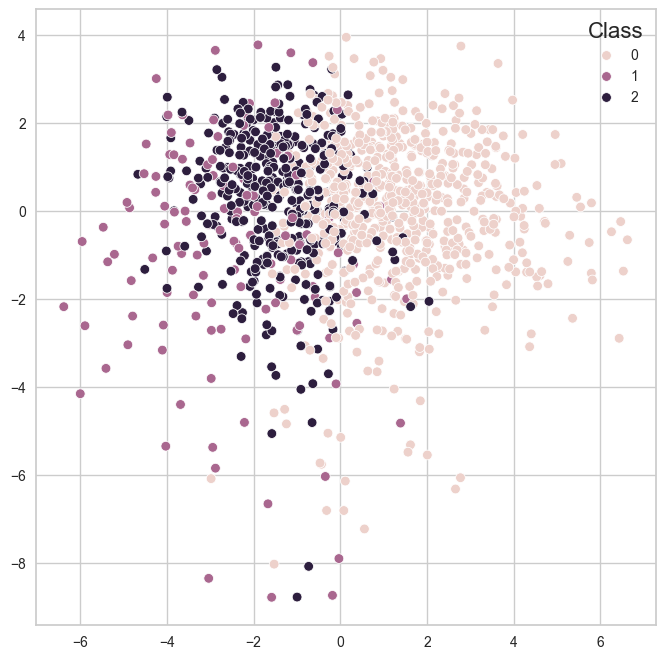

In [14]:
#PCA
X_trans = pca.transform(X_train_pre)
fig = plt.figure(figsize=(8, 8))
sns.scatterplot(x=X_trans[:, 0], y=X_trans[:, 1], hue=y_train);

En aquest PCA, podem veure que les classes són més o menys separables. Veiem que la més predominant és la classe 0, que també és la que s'observa amb un millor clúster al costat dret de l'eix X. Pel que fa a la classe 1 i la classe 2, es veuen més barrejades, encara que la classe 2, a primera vista, sembla que té un clúster més definit respecte a la classe 1.

Però es veu un solapament notable entre les classes.

### Podrien ser les classes linealment separables?

En aquest punt, només podem jutjar a partir de l'anàlisi visual del PCA en 2D, de la variància explicada i de poc més. Però **no podem concloure** si són **linealment separables** amb el que tenim.

Per què? Primer, perquè en el PCA només observem un 15% de la variància, que és molt poca informació. Segon, en la projecció del PCA en dues dimensions, poden col·lapsar classes que en més dimensions potser no col·lapsarien. I per últim, el nostre espai és de més de 200 variables després del one-hot encoding.

El que sí que podem observar és que en el PCA, el clúster de la **classe 0** està més o menys definit i que les **classes 1 i 2** estan més solapades entre elles. Però, ho torno a dir, només estem treballant en dues dimensions.

Per això, **amb el PCA 2D no podem concloure** si són linealment separables o no en l'espai original.

El que sí que podem dir és que, en 2D, la separació no és perfecta (hi ha solapament), així que si hi ha separabilitat lineal, probablement serà **aproximada** i en l'espai complet. 
Ho confirmarem ajustant models lineals (regressió logística i SVM) i comprovant-ne el rendiment sobre el conjunt de test

## Apartat b)
 - Ajusta un Gaussian Naive Bayes (GNB)
 - Avalua la qualitat del model


### GNB

In [15]:
gnb = GaussianNB()
gnb.best_score_ = np.mean(cross_val_score(gnb,X_train_pre,y_train,cv=10))
print(gnb.best_score_)

0.5216666666666667


Jutjant per la validació creuada, el **GNB** només aconsegueix un **accuracy** de ~52%, el qual és bastant baix. De fet, si sempre classifiquéssim com a classe 0, tindríem millor accuracy (56%), és a dir, a priori és un classificador dolent.

Això **no prova** directament que les classes no siguin linealment separables, el GNB fa hipòtesis fortes (independència condicional entre variables i distribucions gaussianes) a més que es tracta d'un model generatiu i no pas discriminatiu, tot aquest cúmul pot fer possible que no funcioni bé en el nostre cas.

Però veurem com es comporta el model per acabar de jutjar-ho bé.

In [16]:
gnb_model = GaussianNB().fit(X_train_pre, y_train)
gnb_model.best_score_ = gnb.best_score_


In [17]:
y_pred_gnb_test = gnb_model.predict(X_test_pre)
results_df = save_results(gnb_model, X_test_pre, y_test, 'GNB', results_df)
print(classification_report(y_test, y_pred_gnb_test))

              precision    recall  f1-score   support

           0       0.89      0.30      0.45       169
           1       0.53      0.87      0.66        31
           2       0.39      0.74      0.51       100

    accuracy                           0.51       300
   macro avg       0.60      0.64      0.54       300
weighted avg       0.69      0.51      0.49       300



Bé, què podem dir? Doncs més o menys era el que esperàvem amb la validació creuada. El model no és capaç de separar bé les classes, ja que l'**accuracy** és de només 51%.

A nivell local, és a dir, per classe, veiem que en general no té un rendiment bo en cap de les classes, ja que els valors de **precision**, **recall** i **f1-score** són bastant baixos. Per a la classe 0, tenim bona precisió però molt mal recall, cosa que significa molts falsos negatius. Per a la classe 1, és la que té un rendiment més equilibrat, amb un f1-score de 66%, però que sigui equilibrat no significa que sigui bo. I per a la classe 2, tenim un recall alt però una precisió pobra, cosa que es pot traduir en molts falsos positius.

Ara amb la matriu de confusió ho veurem més visualment.


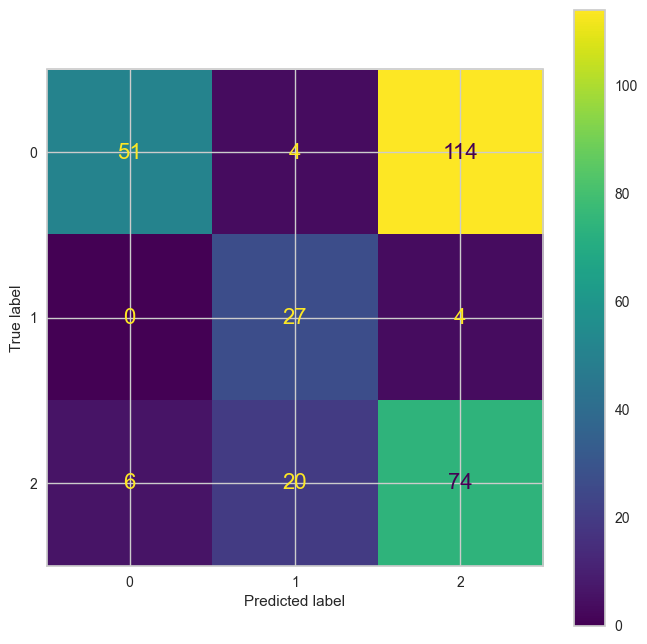

In [18]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(gnb_model, X_test_pre, y_test, ax=plt.subplot());

Veiem una mica el que anàvem dient, la classe 0 té molts falsos negatius (118), dels quals 114 són de la classe 2, és a dir, confon molt la classe 0 amb la 2. La classe 1 té un rendiment acceptable. I finalment, la classe 2, doncs el que dèiem, molts falsos positius.

És a dir, el problema **més greu es que prediu classe 0 com a classe 2**.

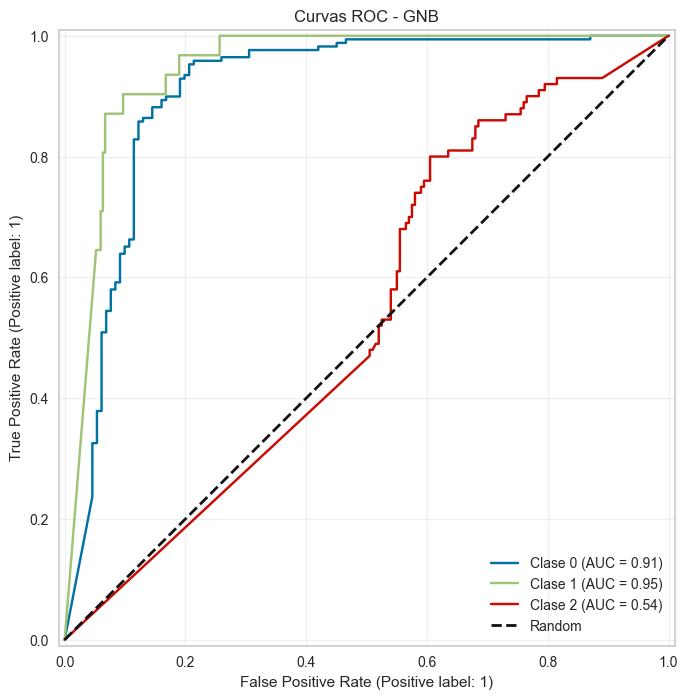

In [19]:

y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_pred_proba = gnb_model.predict_proba(X_test_pre)

plt.figure(figsize=(10, 8))

# Añadir cada curva ROC
for i in range(3):
    RocCurveDisplay.from_predictions(
        y_test_bin[:, i], 
        y_pred_proba[:, i],
        name=f'Clase {i}',
        ax=plt.gca()
    )

# Línea diagonal
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
plt.title('Curvas ROC - GNB')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Amb les curves ROC podem veure el que anavem dient. La pitjor en diferència és la classe 2, ja que té un AUC de només 0.54, i en alguns moments és superada per la línia de l'atzar. Pel que fa la classe 1, és la que té millor rendiment, amb un AUC de 0.95. 

In [20]:
results_df

,train XV acc,test acc,precision score (M),recall score (M),f1 score (M)
GNB,0.522,0.507,0.603,0.638,0.539


### Avaluació 

En general, com hem anat dient, el model **GNB** no és capaç de separar bé les classes. En altres paraules, és un model que no s'adapta al nostre dataset. Té un **accuracy** de test de només 52% (consistent amb la validació creuada), i com hem vist a la matriu de confusió i les corbes ROC, el rendiment per classe és pobre, especialment per les classes 0 i 2.

**Problema principal**: El model confon molt aquestes dues classes (114 de 169 casos de classe 0 els classifica com a classe 2), generant molts falsos negatius per la classe 0 i molts falsos positius per la classe 2, és a dir, sobreprediu la classe 2. Què voldria dir això? Doncs que probablement aquestes dues classes comparteixen regions de l'espai de característiques, o tenen distribucions similars que el model no pot discriminar adequadament amb fronteres de decisió lineals.

Basant-nos en aquest model, confirmem el que havíem dit inicialment: les classes **no** són linealment separables amb aquest conjunt de dades. El GNB, amb les seves limitacions (assumpció d'independència entre variables i fronteres de decisió lineals), no és adequat per aquest problema. Caldrà explorar models no lineals (com SVM amb kernel, arbres de decisió o ensembles) per aconseguir millors resultats, encara que també seria interessant provar altres models lineals (com Logistic Regression) per confirmar que el problema no és específic del GNB.

### Apartat c)
 - Ajusta una regressió logística
 - Ajusta un SVM lineal i explora els seus hiperparàmetres
 - Avalua la qualitat dels models
 - Avalua la importancia dels atributs


### Regressió logística

In [21]:
lr = LogisticRegression(max_iter=10000)
param = {'penalty':['l1', 'l2'], 'C':10**np.linspace(-3,3,51, endpoint=True)}
lr_gs = GridSearchCV(lr, param, cv=10, n_jobs=-1, refit = True)
lr_gs.fit(X_train_pre, y_train);
show_html(pd.DataFrame(lr_gs.cv_results_).loc[:,['params', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score').head().to_html())

lr_prediction = lr_gs.predict(X_test_pre)
results_df = save_results(lr_gs, X_test_pre, y_test, 'Logistic Regression', results_df)

,params,mean_test_score,rank_test_score
33,"{'C': 0.08317637711026708, 'penalty': 'l2'}",0.897,1
43,"{'C': 0.3311311214825911, 'penalty': 'l2'}",0.895,2
45,"{'C': 0.43651583224016566, 'penalty': 'l2'}",0.895,3
37,"{'C': 0.1445439770745928, 'penalty': 'l2'}",0.893,4
35,"{'C': 0.1096478196143185, 'penalty': 'l2'}",0.893,5


Ara ja ens agraden més els resultats. Ja arribem gairebé al 90% d'accuracy en el test, ens quedem a 89,7%.
El millor hiperparametre ha estat:
- **Penalty**: l2
- **C**: 0.08317637711026708
- **Accuracy**: 89.7%

In [22]:
print(classification_report(y_test, lr_prediction))

              precision    recall  f1-score   support

           0       0.96      0.93      0.95       169
           1       0.89      0.77      0.83        31
           2       0.83      0.90      0.87       100

    accuracy                           0.91       300
   macro avg       0.89      0.87      0.88       300
weighted avg       0.91      0.91      0.91       300



Aquí la cosa ja millora. Amb la **regressio logística** ja aconseguim un **accuracy** de 91% amb weighted average de **precission**, **recall** i **f1-score** amb valor de 91%.

A nivell a destacar, la classe 0 és la que té millor rendiment, amb un **f1-score** de 95%, comparant amb el GNB redueix drasticament els falsos negatius. Les altres dues classes també milloren molt, ja que tenen un **f1-score** de 83% i 87% respectivament.

En general la regressió logística és un model lineal que funciona bastant bé en aquest dataset.

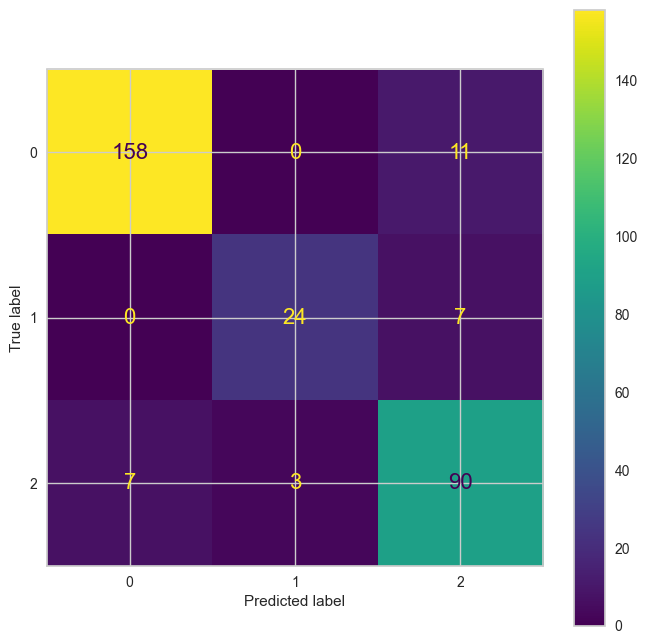

In [23]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lr_gs, X_test_pre, y_test, ax=plt.subplot());

Com es veu en el classification report, la **classe 0** ha millorat dràsticament el seu rendiment en comparació amb GNB. Veiem ara que la **classe 0** ha reduit dràsticament els falsos negatius, el que vol dir que ja no confon tant la classe 0 amb la classe 2. Respecte la **classe 1**, ha millorat la relació precissión-recall. I la **classe 2** també té millor rendiment i molts menys falsos positius.

En resum, la regressió logística ha aconseguit separar les classes molt millor que GNB. Ja que aconsegueix separar la classe 0 i la 2 que era el problema que teniem en el GNB.

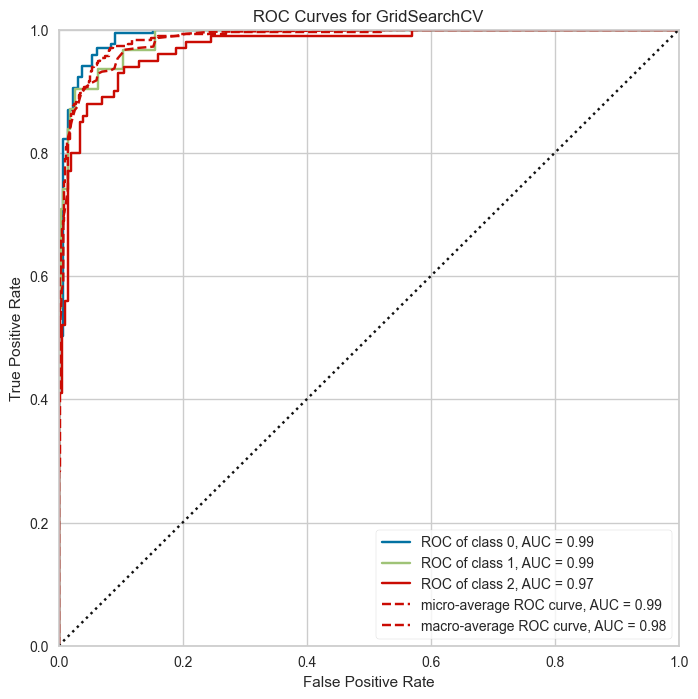

In [24]:
plt.figure(figsize=(8,8));
roc_auc(lr_gs, X_train_pre, y_train, X_test_pre, y_test);

La millora en les curves ROC és espectacular comparada amb GNB, **classe 0** i **classe 1** amb un AUC de 0.99, ens indica una discriminació quasi perfecte, destacant que té millor rendiment la classe 0 que la 1, ja que la corba puja més ràpidament. 
Però la corba que més destaca és la de la **classe 2**, que hem passat d'un AUC de 0.54 a un de 0.97, on cap moment és superat per la línia de l'atzar.

En resum, la regressió logística ha aconseguit discriminar totes les classes. És un model lineal que s'adapta bé al nostre dataset.

### SVM Lineal

In [25]:
param = {'C':10**np.linspace(-3,3,101)}

lsvc = SVC(kernel='linear', max_iter=25000, random_state=0)
lsvc_gs = BayesSearchCV(lsvc,param,n_iter=niter, cv=cv, n_jobs=-1, refit=True, random_state=0)
lsvc_gs.fit(X_train_pre, y_train);

show_html(pd.DataFrame(lsvc_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
25,{'C': 0.047863009232263824},0.906,1
49,{'C': 0.04168693834703353},0.903,2
4,{'C': 0.023988329190194897},0.902,3
27,{'C': 0.1096478196143185},0.902,4
48,{'C': 0.054954087385762455},0.902,4


Els millors hiperparàmetres són:
- **C**: 0.047863009232263824
- **Validació creuada accuracy**: 90.6%

Observacions importants:
- El SVM lineal aconsegueix un rendiment molt similar al de la Logistic Regression.
- Els paràmetres C propers també ofereixen molt bon rendiment.

In [26]:
print(classification_report(y_test, lsvc_gs.predict(X_test_pre)))
results_df = save_results(lsvc_gs, X_test_pre, y_test, 'linear SVM binary', results_df)

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       169
           1       0.87      0.87      0.87        31
           2       0.87      0.90      0.89       100

    accuracy                           0.92       300
   macro avg       0.90      0.91      0.90       300
weighted avg       0.92      0.92      0.92       300



Els resultats són molt bons amb un **accuracy** de test de 92% i totes les mètriques weighted a 92%, indicant un rendiment excel·lent.

A nivell individual per classe, totes respecte **LR** tenen una millora, sent la màxima la de la classe 1, que el **f1-score** és 4% millor, (87% vs 83%).

En general, el SVM lineal supera la regressió logística en totes les classes, demostrant una millor discriminació entre les classes, especialment per la classe 1.

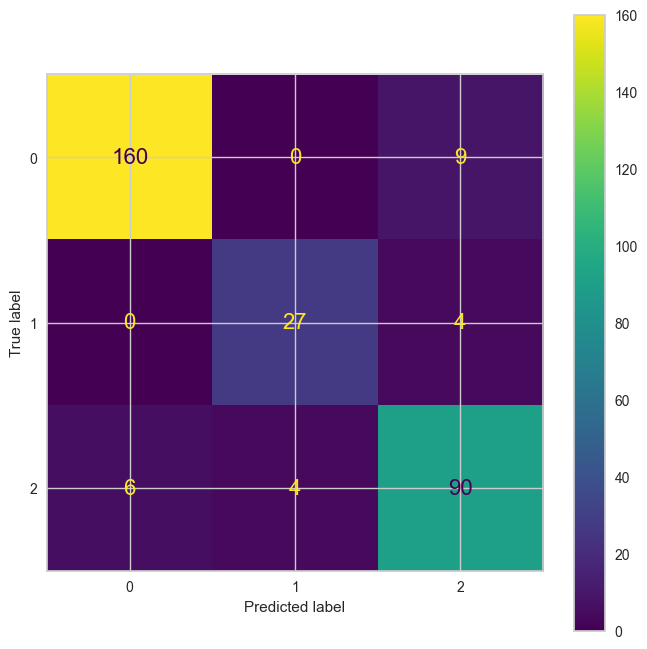

In [27]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lsvc_gs, X_test_pre, y_test, ax=plt.subplot());

Confussion matrix molt semblant a l'anterior, però aquesta podriem dir que és millor ja que n'hi ha menys falsos negatius tant per la classe 0 com la classe 1. 

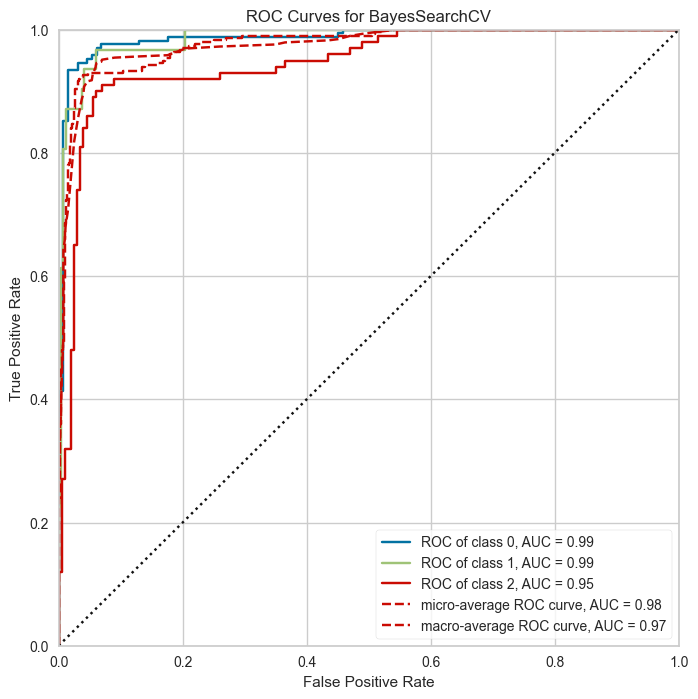

In [28]:
plt.figure(figsize=(8,8));
roc_auc(lsvc_gs, X_train_pre, y_train, X_test_pre, y_test);

Curves molt bones, podem veure igual que en les de **LR**, el AUC de les classes 0, 1 i 2, és 0.99, 0.99 i 0.95 respectivament. Em soprren que el valor de la classe 2, és més baix que respecte **LR**, ja que a priori el classification report ha mostrat millors resultats en el **SVM** que en **LR**.

### Avaluar qualitat dels models

In [29]:
results_df.sort_values(by=['test acc'], ascending=False)

,train XV acc,test acc,precision score (M),recall score (M),f1 score (M)
linear SVM binary,0.906,0.923,0.903,0.906,0.904
Logistic Regression,0.897,0.907,0.893,0.870,0.880
GNB,0.522,0.507,0.603,0.638,0.539


**SVM Lineal**:
- Test accuracy: __92.3%__
- Totes les mètriques macro superen el 90%: precision (90.3%), recall (90.6%), f1-score (90.4%)
- Rendiment equilibrat entre totes les classes
- Excel·lent qualitat general, amb capacitat de discriminació entre les tres classes

**Regressió Logística**:
- Test accuracy: **90.7%**
- Mètriques macro entre 87-89%: precision (89.3%), recall (87.0%), f1-score (88.0%)
- Generalització excel·lent (diferència train-test de només 1%)
- Qualitat molt bona, model consistent i estable

**GNB**:
- Test accuracy: **50.7%**
- Mètriques macro baixes: precision (60.3%), recall (63.8%), f1-score (53.9%)
- Rendiment insuficient per aquest problema
- El problema principal és que confon massa la classe 0 amb la 2
- Curva ROC de la classe 2 desastrossa.

Al inici, jutjant només amb el PCA i els resultats del GNB, havia dit que les classes no eren linealment separables. Però jutjant pels resultats de **LR** i **SVM** doncs demostren el contrari, que les classes **sí** son linealment separables.

Però per què **LR** i **SVM** són millors que el **GNB**? Doncs principalment perquè **GNB** assumeix independència condicional entre totes les variables (donada la classe), cosa que clarament no es compleix en aquest dataset on les opinions sobre diferents aspectes de la IA estan correlacionades. A més, **GNB** assumeix que cada variable segueix una distribució gaussiana, mentre que **LR** i **SVM** són models discriminatius que no assumeixen cap distribució específica per les dades, simplement busquen la millor frontera de decisió lineal.

### Importància dels atributs (pesos)
En un model lineal, la importància d'un atribut es pot interpretar a partir del mòdul del seu pes. A continuació extraiem els pesos per classe i comparem quins atributs contribueixen més a la decisió per **LR** i **SVM**.

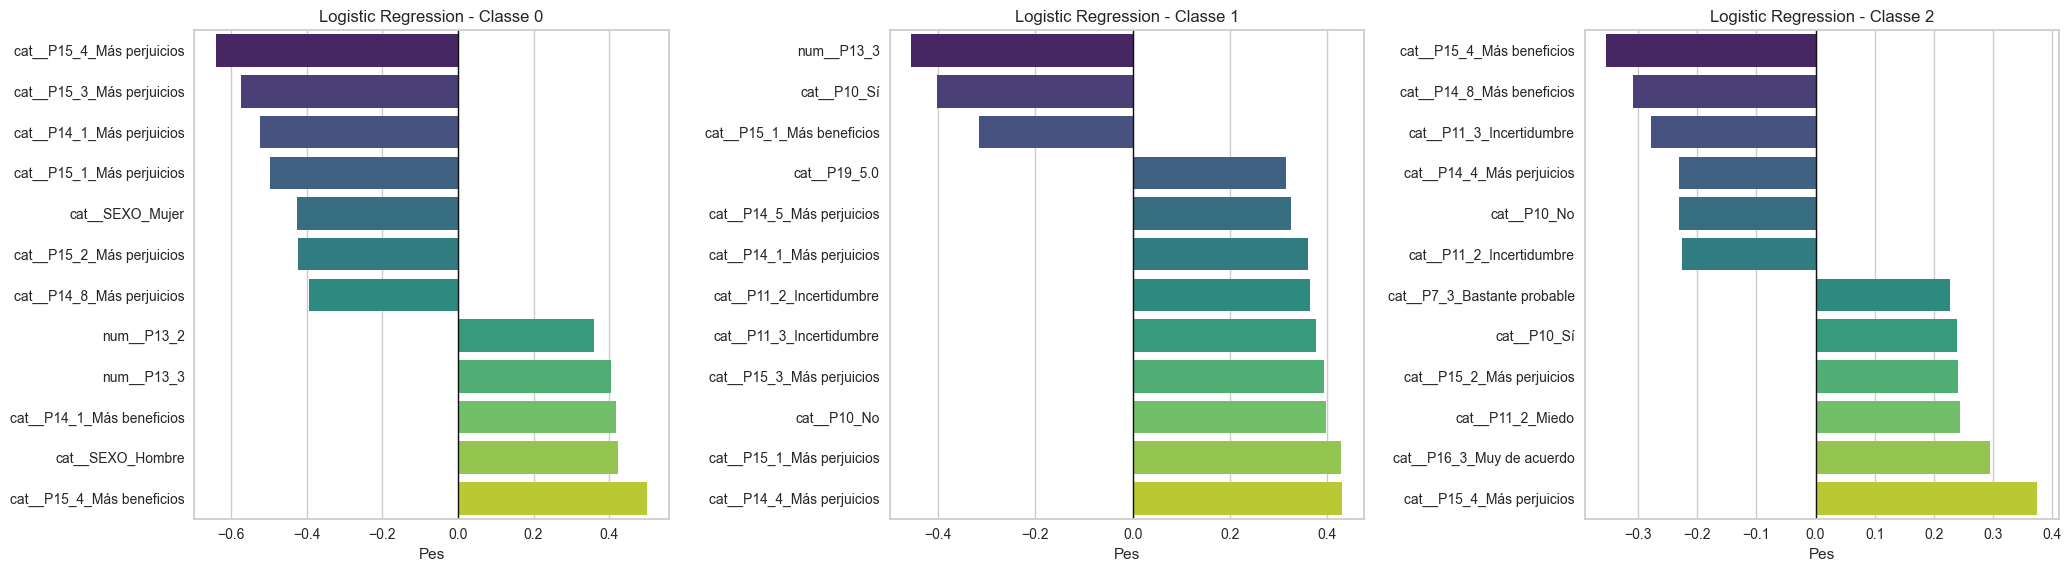

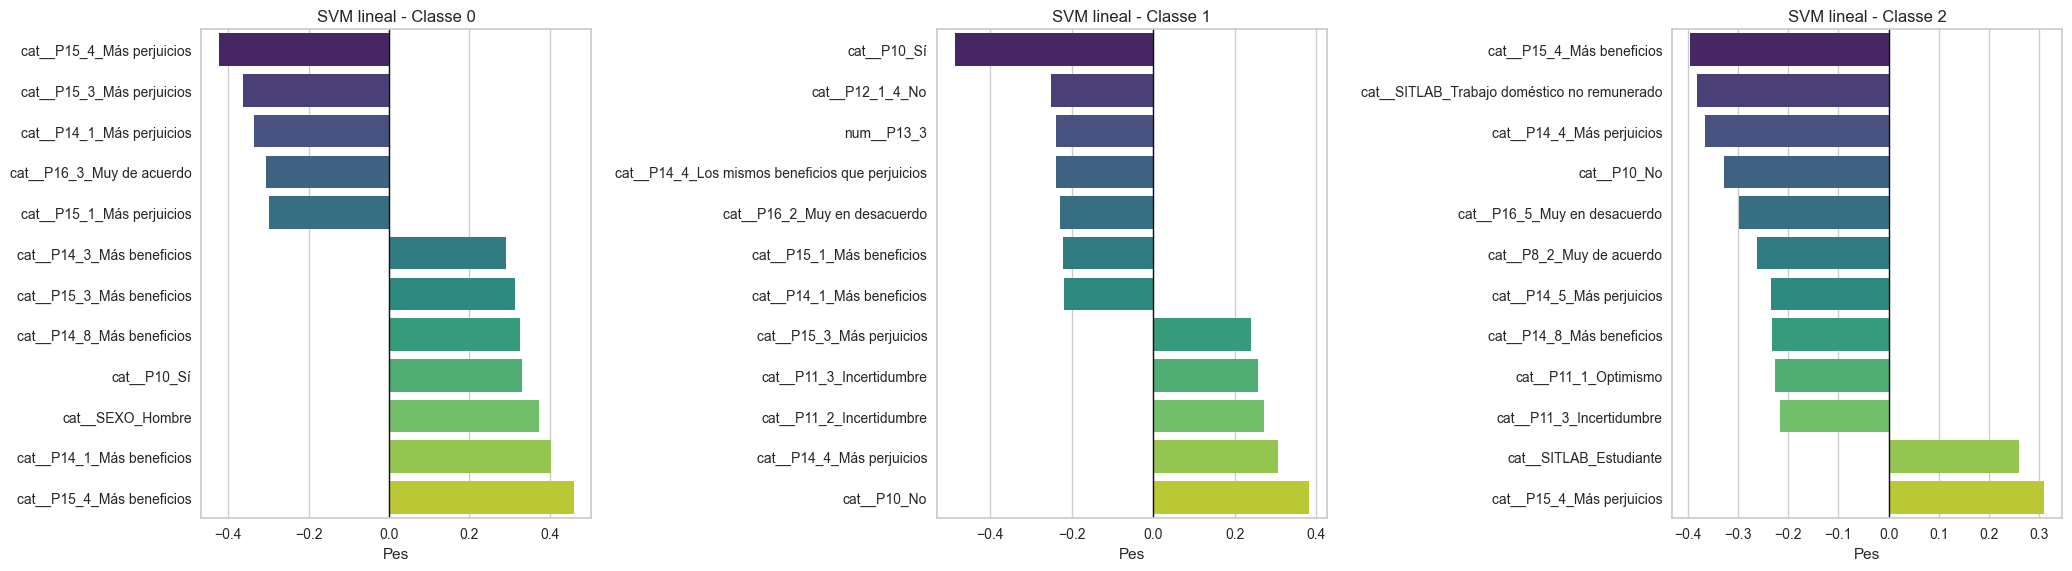

Classe 0 — atributs comuns (LR ∩ SVM):
  - cat__P14_1_Más beneficios
  - cat__P14_1_Más perjuicios
  - cat__P15_1_Más perjuicios
  - cat__P15_3_Más perjuicios
  - cat__P15_4_Más beneficios
  - cat__P15_4_Más perjuicios
  - cat__SEXO_Hombre

Classe 1 — atributs comuns (LR ∩ SVM):
  - cat__P10_No
  - cat__P10_Sí
  - cat__P11_2_Incertidumbre
  - cat__P11_3_Incertidumbre
  - cat__P14_4_Más perjuicios
  - cat__P15_1_Más beneficios
  - cat__P15_3_Más perjuicios
  - num__P13_3

Classe 2 — atributs comuns (LR ∩ SVM):
  - cat__P10_No
  - cat__P11_3_Incertidumbre
  - cat__P14_4_Más perjuicios
  - cat__P14_8_Más beneficios
  - cat__P15_4_Más beneficios
  - cat__P15_4_Más perjuicios



In [30]:
feature_names =  preprocessor.get_feature_names_out()

# Logistic Regression
lr_coef = lr_gs.best_estimator_.coef_
lr_classes = lr_gs.best_estimator_.classes_

# SVM 
best_c = float(lsvc_gs.best_params_.get('C', 1.0))
svm_ovr = OneVsRestClassifier(LinearSVC(C=best_c, max_iter=50000, random_state=0))
svm_ovr.fit(X_train_pre, y_train)
svm_coef = np.vstack([est.coef_.ravel() for est in svm_ovr.estimators_])
svm_classes = svm_ovr.classes_

def get_top_features(coef_matrix, classes, feature_names, top_n=12):
    results = {}
    for idx, cls in enumerate(classes):
        top_idx = np.argsort(np.abs(coef_matrix[idx]))[::-1][:top_n]
        results[cls] = pd.DataFrame({
            'feature': feature_names[top_idx],
            'weight': coef_matrix[idx, top_idx]
        }).sort_values('weight', key=abs, ascending=False)
    return results

lr_top = get_top_features(lr_coef, lr_classes, feature_names)
svm_top = get_top_features(svm_coef, svm_classes, feature_names)

def plot_top_features(top_dict, title):
    fig, axes = plt.subplots(1, len(top_dict), figsize=(7*len(top_dict), 6))
    if len(top_dict) == 1:
        axes = [axes]
    
    for ax, (cls, df) in zip(axes, top_dict.items()):
        df_sorted = df.sort_values('weight')
        sns.barplot(data=df_sorted, y='feature', x='weight', ax=ax, palette='viridis')
        ax.set_title(f"{title} - Classe {cls}")
        ax.axvline(0, color='k', lw=1)
        ax.set_xlabel('Pes')
        ax.set_ylabel('')
    
    plt.tight_layout()
    plt.show()


plot_top_features(lr_top, 'Logistic Regression')
plot_top_features(svm_top, 'SVM lineal')

rows = []
for cls in sorted(set(lr_classes).intersection(set(svm_classes))):
    lr_set = set(lr_top[cls]['feature'].tolist())
    svm_set = set(svm_top[cls]['feature'].tolist())
    inter = lr_set.intersection(svm_set)
    union = lr_set.union(svm_set)
    rows.append({
        'classe': cls,
        'top_n': len(lr_set),
        'interseccio': len(inter),
        'jaccard': (len(inter) / len(union)) if union else np.nan
    })
    print(f"Classe {cls} — atributs comuns (LR ∩ SVM):")
    for feat in sorted(inter):
        print('  -', feat)
    print()


Analitzem els pesos assignats per LR i SVM a cada atribut per classe, mostrem només el TOP 12 per classe, ja que després del one-hot encoding el nombre total de variables és molt elevat i no seria pràctic mostrar-les totes.

**Què veiem en els resultats?** Diverses coses interessants:

**Variables comunes entre models**: Tot i que el TOP 12 no és idèntic entre LR i SVM, hi ha atributs que apareixen en ambdós, indicant que són especialment rellevants:

- **Classe 0** (7 comuns): Predominen variables sobre **perjudicis de la IA** (`P14_1`, `P15_1`, `P15_3`, `P15_4_Más perjuicios`) i també apareix `SEXO_Hombre`. Perfil més **escèptic**.

- **Classe 1** (8 comuns): Mix de variables de **coneixement** (`P10`, `P11_Incertidumbre`, `P13_3`) amb percepcions mixtes sobre beneficis i perjudicis. Perfil més **equilibrat**.

- **Classe 2** (6 comuns): Presència tant de **beneficis com perjudicis** (`P14`, `P15`) i també d'**incertitud** (`P10_No`, `P11_3_Incertidumbre`). Perfil més **ambivalent**.

**Atributs oposats dins d'una mateixa classe**: És curiós observar que en algunes classes apareixen atributs oposats. Per exemple, en la Classe 1 trobem tant `P10_Sí` com `P10_No`, indicant que el **coneixement (o la seva absència) sobre la IA és un factor discriminant clau** per aquesta classe, i que el seu signe determina la direcció de la predicció.

Ambdós models identifiquen consistentment com a més importants les **percepcions sobre beneficis/perjudicis** (`P14`, `P15`) i **variables d'opinió/coneixement** (`P10`, `P11`, `P13`). La coherència entre LR i SVM valida la robustesa d'aquests resultats.

## Apartat d)
- Ajusta un Gradient Boosting
- Ajusta un Extra Trees classifier
- Comparar la qualitats dels models 
- Calcula la permutation importance sobre el test
- Compara els atributs, hi ha acord entre els models?

### Gradient Boosting

In [31]:
param = {'n_estimators': [5,10,25,40, 50, 75,100, 200], 
         'loss':['log_loss'], 
         'criterion':['friedman_mse', 'squared_error'], 
         'max_depth':[None, 1, 2, 3,  5,  8, 9,10,15],
         'min_samples_leaf':[1,2,3,5,10], 
         'learning_rate':[0.1,0.5, 1,3, 5, 10, 15]}

gb =  GradientBoostingClassifier(random_state=0,n_iter_no_change=5)
gb_bs =  BayesSearchCV(gb,param,n_iter=niter, cv=cv, n_jobs=-1, refit=True, random_state=0)
gb_bs.fit(X_train_pre, y_train);

In [32]:
show_html(pd.DataFrame(gb_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
13,"{'criterion': 'friedman_mse', 'learning_rate': 0.5, 'loss': 'log_loss', 'max_depth': 2, 'min_samples_leaf': 10, 'n_estimators': 200}",0.867,1
18,"{'criterion': 'squared_error', 'learning_rate': 0.5, 'loss': 'log_loss', 'max_depth': 2, 'min_samples_leaf': 10, 'n_estimators': 100}",0.867,1
24,"{'criterion': 'friedman_mse', 'learning_rate': 0.5, 'loss': 'log_loss', 'max_depth': 2, 'min_samples_leaf': 10, 'n_estimators': 50}",0.867,1
32,"{'criterion': 'friedman_mse', 'learning_rate': 0.5, 'loss': 'log_loss', 'max_depth': 2, 'min_samples_leaf': 10, 'n_estimators': 75}",0.867,1
16,"{'criterion': 'friedman_mse', 'learning_rate': 0.5, 'loss': 'log_loss', 'max_depth': 2, 'min_samples_leaf': 10, 'n_estimators': 40}",0.866,5


Tots els resultats són similars entre ells, amb una **accuracy** al test del 86.7%. Els hiperparàmetres guanyadors han estat:  
- **n_estimators**: 200
 - **learning_rate**: 0.5
 - **max_depth**: 3
 - **min_samples_leaf**: 1
 - **loss**: log_loss
 - **criterion**: squared_error
 - **Accuracy**: 86.7%

S'observa que el **Gradient Boosting** té un rendiment inferior a la **Regressió Logística** (86.7% vs 91%), tot i ser un model més complex.


In [33]:
print(classification_report(y_test, gb_bs.predict(X_test_pre)))
results_df = save_results(gb_bs, X_test_pre, y_test, 'Gradient Boosting', results_df)

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       169
           1       0.89      0.77      0.83        31
           2       0.82      0.89      0.86       100

    accuracy                           0.90       300
   macro avg       0.89      0.86      0.87       300
weighted avg       0.90      0.90      0.90       300



El model de Gradient Boosting ofereix un rendiment molt bo, amb un **accuracy** del 91% i totes les mètriques weighted també al 91%. Això el situa al mateix nivell que la **Regressió Logística** i el **SVM lineal**, indicant que és capaç de discriminar bé entre les classes.

A nivell individual, observem que la **classe 1** té una precisió del 100%, però un recall del 81%, el que implica alguns falsos negatius. Tot i això, el seu **f1-score** és del 89%, que és molt bo. Les **classes 0 i 2** mostren un rendiment equilibrat, amb **f1-scores** del 93% i 86%, respectivament.

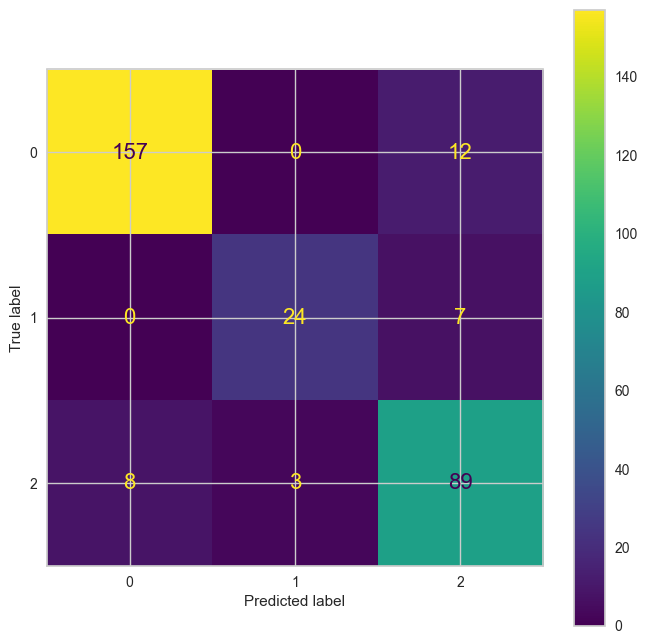

In [34]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(gb_bs, X_test_pre,y_test, ax=plt.subplot());

Aquesta confussion matrix es una mica diferent de les que haviem vist ja. En general, el **Gradient Boosting** és un model robust que aconsegueix resultats consistents i comparables als millors models lineals ajustats prèviament. Tot i que confon lleugerament les classes 0 i 2 (11 casos en cada direcció segons la matriu de confusió).

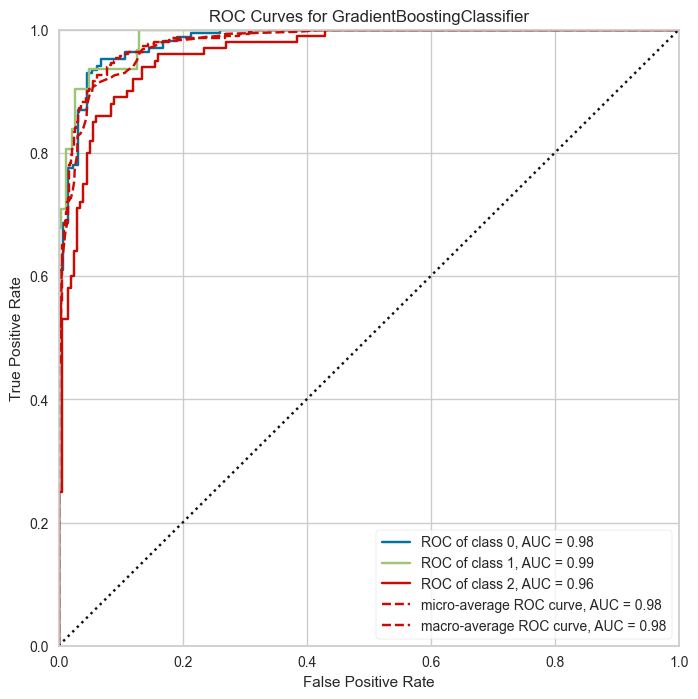

In [35]:
fig, ax = plt.subplots(figsize=(8, 8))
visualizer = ROCAUC(gb_bs.best_estimator_, classes=[0, 1, 2], ax=ax)

visualizer.fit(X_train_pre, y_train)
visualizer.score(X_test_pre, y_test)
visualizer.show();

Res nou a dir, molt bones curves ROC, amb AUCs molt alts per totes les classes: 0.98 per la classe 0, 0.99 per la classe 1 i 0.96 per la classe 2. Això confirma la capacitat del model per discriminar entre les classes.

### Extra Trees Classifier

In [36]:
param = {'n_estimators': [5,10,25,40, 50, 75,100, 200], 
         'criterion':['gini', 'entropy'], 
         'max_depth':[None, 1, 2, 3,  5,  8, 9,10,15],
         'min_samples_leaf':[1,2,3,5,10]}

et = ExtraTreesClassifier(random_state=0, n_jobs=-1)
et_gs = GridSearchCV(et, param,cv=cv,n_jobs=-1,refit=True,scoring='f1_macro')
et_gs.fit(X_train_pre, y_train)

GridSearchCV(cv=10, estimator=ExtraTreesClassifier(n_jobs=-1, random_state=0),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 1, 2, 3, 5, 8, 9, 10, 15],
                         'min_samples_leaf': [1, 2, 3, 5, 10],
                         'n_estimators': [5, 10, 25, 40, 50, 75, 100, 200]},
             scoring='f1_macro')

In [37]:
show_html(pd.DataFrame(et_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
686,"{'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 1, 'n_estimators': 100}",0.847,1
367,"{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 200}",0.847,2
7,"{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 200}",0.846,3
687,"{'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 1, 'n_estimators': 200}",0.846,4
327,"{'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'n_estimators': 200}",0.843,5


El model Extra Trees Classifier ha aconseguit un **accuracy** del 84.7% en el conjunt de test, que és inferior al Gradient Boosting (91%) i també als models lineals com la Regressió Logística i el SVM.

Tots els resultats són similars entre ells, amb una **accuracy** al test del 84.7%. Els hiperparàmetres guanyadors han estat:
- **criterion**: entropy
- **max_depth**: 15
- **min_samples_leaf**: 1
- **n_estimators**: 100
- **Accuracy**: 84.7%

Veiem que a simple vista te pitjor rendiment que el Gradient Boosting.

In [38]:
print(classification_report(y_test, et_gs.predict(X_test_pre)))
results_df = save_results(et_gs, X_test_pre, y_test, 'Extra Trees', results_df)

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       169
           1       0.96      0.74      0.84        31
           2       0.86      0.85      0.85       100

    accuracy                           0.90       300
   macro avg       0.91      0.85      0.88       300
weighted avg       0.90      0.90      0.90       300



Aquest model té un **accuracy** del 90%, amb mètriques weighted totes al 90%. Son bon resultats, pero inforiors als del Gradient Boosting i als models lineals (menys el GNB).

La classe amb millor rendiment és la 0, amb un **f1-score** del 94%. La classe 1 té un rendiment més baix, amb un **f1-score** del 84%, degut a un recall del 74%. La classe 2 té un rendiment equilibrat, amb un **f1-score** del 85%.

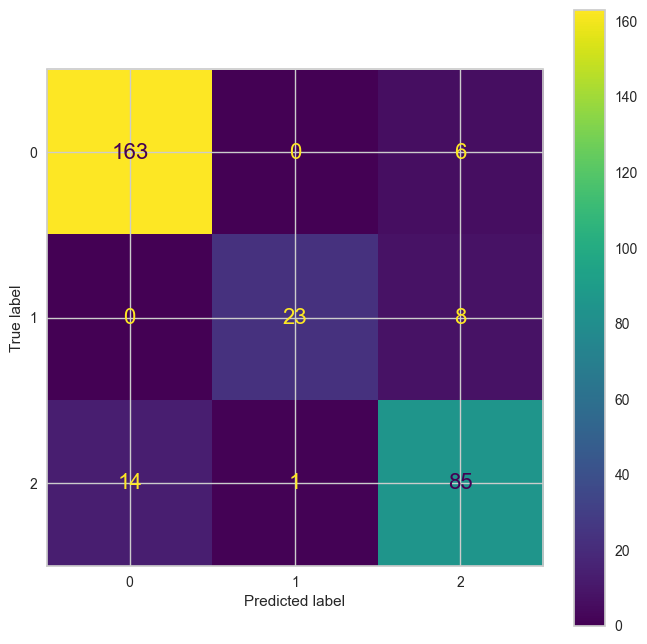

In [39]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(et_gs, X_test_pre,y_test, ax=plt.subplot());

Si que es cert que comparant amb la confussion matrix del **Gradient Boosting**, veiem que aquest model comete més errors, especialment entre les **classes 0 i 2**. Confon més la **classe 2** (la classifica com a 0), però si que a l'inversa s'ha reduit només a 6 errors. La **classe 1** també té un rendiment similar.

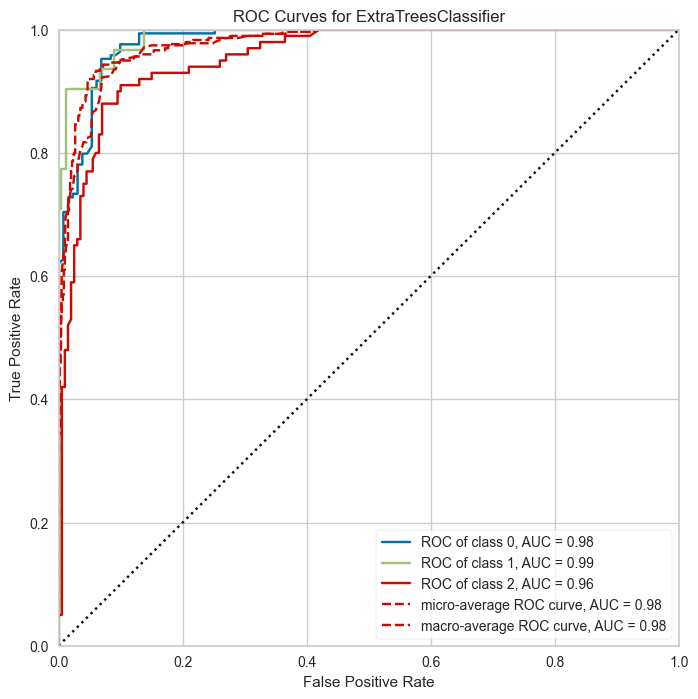

In [40]:
fig, ax = plt.subplots(figsize=(8, 8))
visualizer = ROCAUC(et_gs.best_estimator_, classes=[0, 1, 2], ax=ax)

visualizer.fit(X_train_pre, y_train)
visualizer.score(X_test_pre, y_test)
visualizer.show();

Les corves ROC ens mostren igual que els altres model, un rendiment molt bo, amb AUCs amb els mateixos valors que el Gradient Boosting: 0.98 per la classe 0, 0.99 per la classe 1 i 0.96 per la classe 2.

### Comparar qualitat dels models

In [41]:
results_df.sort_values(by=['test acc'], ascending=False)

,train XV acc,test acc,precision score (M),recall score (M),f1 score (M)
linear SVM binary,0.906,0.923,0.903,0.906,0.904
Logistic Regression,0.897,0.907,0.893,0.870,0.880
Extra Trees,0.847,0.903,0.913,0.852,0.878
Gradient Boosting,0.867,0.900,0.888,0.864,0.874
GNB,0.522,0.507,0.603,0.638,0.539


Analitzem els resultats de tots els models entrenats i comparem el seu rendiment:

1. **SVM Lineal**: 92.3%
2. **Regressió Logística**: 90.7%
3. **Extra Trees**: 90.3%
4. **Gradient Boosting**: 89.3%
5. **GNB**: 50.7%

Veiem que els millors models són els lineals (SVM i LR), ara avaluare més detalladament cada model menys els lineals ja que ho hem fet en l'apartat anterior.

**Extra Trees** 
- Accuracy 90.3% (millor que GB)
- Excel·lent precision (91.3%), la més alta entre tots els models.
- Millor en la classe 0 (f1-score del 94%).
- Rendiment més baix en la classe 1 (recall del 74%).

**Gradient Boosting** 
- Accuracy 89.3%
- Millor precision per la classe 1 (100%), però recall més baix (81%).
- Excel·lent discriminació de les classes 0 i 2.
- Curves ROC amb AUCs molt alts (0.98, 0.99, 0.96).

El millor model és el **SVM**, és el que té millor accuraccy en test i mètriques equilibrades. Ni **GB** ni **ET** son capaços de superar els models lineals, el que afirma el que hem dit abans, que **les classes son linealment separables**.


In [42]:
# Gradient Boosting
print("Top 15 Gradient Boosting\n")
gb_perm_importance = permutation_importance(gb_bs.best_estimator_, X_test_pre, y_test, 
                                            scoring='f1_macro', n_repeats=10, random_state=42)
gb_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': gb_perm_importance.importances_mean,
    'std': gb_perm_importance.importances_std
}).sort_values('importance', ascending=False).head(15)

print(gb_imp_df.to_string(index=False))

# Extra Trees
print("\n\nTop 15 Extra Trees\n")
et_perm_importance = permutation_importance(et_gs.best_estimator_, X_test_pre, y_test, 
                                            scoring='f1_macro', n_repeats=10, random_state=42)
et_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': et_perm_importance.importances_mean,
    'std': et_perm_importance.importances_std
}).sort_values('importance', ascending=False).head(15)

print(et_imp_df.to_string(index=False))


Top 15 Gradient Boosting

                  feature  importance   std
              cat__P10_No       0.069 0.010
               num__P13_3       0.048 0.016
cat__P14_5_Más perjuicios       0.030 0.008
cat__P15_1_Más perjuicios       0.023 0.013
cat__P14_7_Más perjuicios       0.018 0.005
cat__P15_3_Más perjuicios       0.014 0.007
cat__P14_4_Más perjuicios       0.012 0.006
               num__P13_2       0.011 0.009
cat__P15_4_Más perjuicios       0.010 0.003
   cat__P7_3_Muy probable       0.010 0.006
cat__P14_3_Más perjuicios       0.008 0.009
cat__P14_3_Más beneficios       0.008 0.007
cat__P14_1_Más perjuicios       0.008 0.007
             cat__P19_4.0       0.008 0.005
                num__P3_4       0.008 0.005


Top 15 Extra Trees

                  feature  importance   std
cat__P14_4_Más perjuicios       0.032 0.006
cat__P15_3_Más perjuicios       0.023 0.011
cat__P14_6_Más perjuicios       0.020 0.009
cat__P15_4_Más perjuicios       0.015 0.012
cat__P14_1_Más perjuicios   

A simple vista aquest output és un caos, però mirant-ho bé podem treure bones conclusions.

El primer que destaca és que l'atribut **més important** no és el mateix per **Gradient Boosting** i **Extra Trees**. El primer té `cat__P10_No` (0.0915) i el segon té `cat__P14_4_Más perjuicios` (0.0322). Respecte al que fa el primer atribut de **Gradient Boosting**, amb diferència és el que està més separat de la resta, ja que el segon té un pes de 0.0366; en canvi, en **ET** estan més junts. Els dos models corroboren que han de tenir més pes les percepcions sobre les variables que tenen "Más perjuicios", especialment la P14 i P15, que apareixen en els dos TOP.

Pel que fa a **GB**, dóna més importància a `P10_No`, i aquesta té més del triple de pes que la segona. També cal afegir que té més variables numèriques en el seu top.

D'altra banda, **ET** té els pesos més distribuïts entre múltiples variables, i dóna més importància a les variables categòriques. Al tenir el pes tan repartit, fa que cap variable predomini sobre les altres per ella sola.

El que està clar és que **GB** i **ET** segueixen metodologies diferents: el primer troba la millor variable i, per tant, l'explotarà al màxim, mentre que el segon distribueix la feina en més d'una, en múltiples variables.



### Compara atributs amb models anteriors

Doncs anem veient un comportament semblant al dels models lineals. És a dir, en tots els models hi ha variables que tenen gran pes, com ara `cat__P14_4_Más perjuicios`, `cat__P15_4_Más perjuicios`, `cat__P15_1_Más perjuicios`, `cat__P15_3_Más perjudicis`, entre altres. És a dir, aquestes variables, que són totes de percepció de perjudicis, tenen una gran importància entre tots els models, és a dir, són un factor important.

També podem veure que les variables `P10_No` (sent la de més pes al GB), `P10_Sí` i `P11_3_Incertidumbre` també es repeteixen bastant, és a dir, també són factors clau.

El que també tenen en comú molts models és que pràcticament totes les variables són categòriques, i hi ha molt poques de numèriques en el TOP. L'única que destaca, que apareix més d'una vegada, és la `P13_3`, especialment pels lineals i el GB.

Però sí que podem veure que hi ha diferències bastant extremes en la metodologia de cada model. Com ara, en el Gradient Boosting, l'atribut `P10_No` domina sobre els altres, pràcticament triplica el segon. També, en aquest model, els pesos es concentren de manera escalada i en poques variables, és a dir, n'hi ha poques que tinguin un pes suficient per valdre's per elles mateixes. En canvi, en l'ET són més uniformes, és una distribució més democràtica, el que ens fa pensar que ET explora més camins ja que no depèn d'una sola variable.

Sí que és cert que ET té variables úniques al TOP que no havien aparegut encara, com ara `cat__P14_6_Más perjuicios` i `cat__P16_2_Muy de acuerdo`.

Pel que fa als models lineals, distribueixen el pes de manera diferent en funció de la classe, és a dir, cada classe té pesos específics, el que fa que les variables importants (més discriminatives) siguin diferents per cada classe.

### Hi ha acord entre els models?

**Sí**, que hi ha acord. Com he anat dient abans, hi ha unes quantes variables que es repeteixen i tenen presència en tots o gairebé tots els models. Aquestes són les que provenen de `P14` i `P15` pel que fa a perjudicis, i després també es repeteixen les que provenen de `P10` i `P11`.

Dels 4 models que estem avaluant, cadascun discrimina els pesos d'una forma o altra, però tots aconsegueixen arribar a un **accuracy** al voltant del 90%, el que ens indica que no hi ha un únic camí per assolir-ho. Però el que sí que tenen en comú és que les variables que he anat dient al llarg d'aquest apartat les tenen totes en comú.

També com a matís, la majoria de models només contemplen variables categòriques.

El que esta clar, es que si volguessim reduir la dimensionalitat del problema, hauriem de mantenir les variables ``P14`` (totes), ``P15`` (totes), ``P10``, ``P11`` i ``P13_3`` i seguiriem tenint gran poder predictiu.

## Apartat e)
 - Entrena un StackedClassifer (amb els 3 millors models)
 - Calcula la permutation importance
 - Compara els atributs més importants amb els dels apartats anteriors

### Stacking Classifier

Segons els resultats obtinguts, els 3 millors models són:
1. **SVM Lineal**: 92.3% accuracy
2. **Regressió Logística**: 90.7% accuracy
3. **Extra Trees**: 90.3% accuracy

Utilitzarem aquests models com a estimadors base del StackingClassifier, amb una regressió logística com a meta-model (final_estimator) per combinar les seves prediccions.

In [43]:
best_lr = LogisticRegression(penalty='l2', C=lr_gs.best_params_['C'], max_iter=10000, random_state=0)
best_svm = SVC(kernel='linear', C=float(lsvc_gs.best_params_['C']), max_iter=25000,probability=True, random_state=0)
best_et = ExtraTreesClassifier(criterion=et_gs.best_params_['criterion'],max_depth=et_gs.best_params_['max_depth'],min_samples_leaf=et_gs.best_params_['min_samples_leaf'],
    n_estimators=et_gs.best_params_['n_estimators'],random_state=0,n_jobs=-1)

estimators = [
    ('lr', best_lr),
    ('svm', best_svm),
    ('et', best_et)
]

stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=10000, random_state=0), cv=5, n_jobs=-1)
stacking_clf.fit(X_train_pre, y_train)

stacking_clf.best_score_ = np.mean(cross_val_score(stacking_clf, X_train_pre, y_train, cv=10, n_jobs=-1))
print(stacking_clf.best_score_)


0.9116666666666667


El **StackingClassifier** aconsegueix un **accuracy de validació creuada del 91.17%**, que representa la puntuació més alta de tots els models treballats en aquest dataset.

Aquest bon rendiment suggereix que el Stacking aprofita les fortaleses complementàries dels 3 models base (**SVM**, **LR**, **ET**), combinant les seves diferents perspectives per millorar la predicció global. Ara veurem com es comporta sobre el conjunt de test.

In [44]:
print(classification_report(y_test,  stacking_clf.predict(X_test_pre)))
results_df = save_results(stacking_clf, X_test_pre, y_test, 'Stacking Classifier', results_df)

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       169
           1       0.96      0.84      0.90        31
           2       0.88      0.93      0.90       100

    accuracy                           0.93       300
   macro avg       0.93      0.91      0.92       300
weighted avg       0.94      0.93      0.93       300



El **StackingClassifier** aconsegueix un **accuracy de test del 93%**, la puntuació més alta obtinguda entre tots els models.

A nivell de classe, el rendiment és excel·lent: la **classe 0** té un **f1-score** del 96% (precision 96%, recall 95%), la **classe 1** del 90% (precision 96%, recall 84%), i la **classe 2** del 90% (precision 88%, recall 93%). Pràcticament totes les mètriques superen el 90%, excepte el **recall** de la classe 1 (84%) i la **precision** de la classe 2 (88%). Aquests resultats anticipen una matriu de confusió amb pocs errors i corbes ROC properes a un AUC = 1.

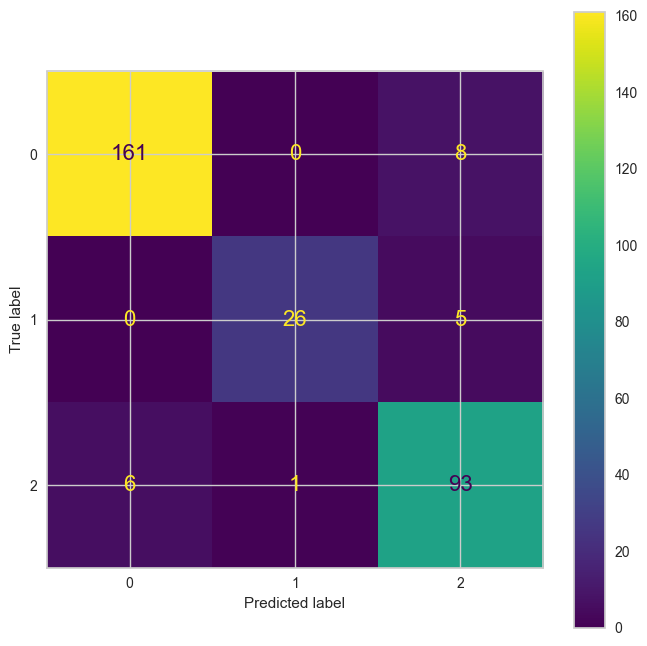

In [45]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(stacking_clf, X_test_pre, y_test, ax=plt.subplot());

El que deiem en el classification report, aquesta matriu de confusió és la que té la diagonal més precisa de tots els models. Els pocs errors que comet són principalment confusions entre la **classe 0** i la **classe 2** (en ambdues direccions), amb només 8 casos de classe 0 classificats com a 2 i 7 casos de classe 2 classificats com a 0.

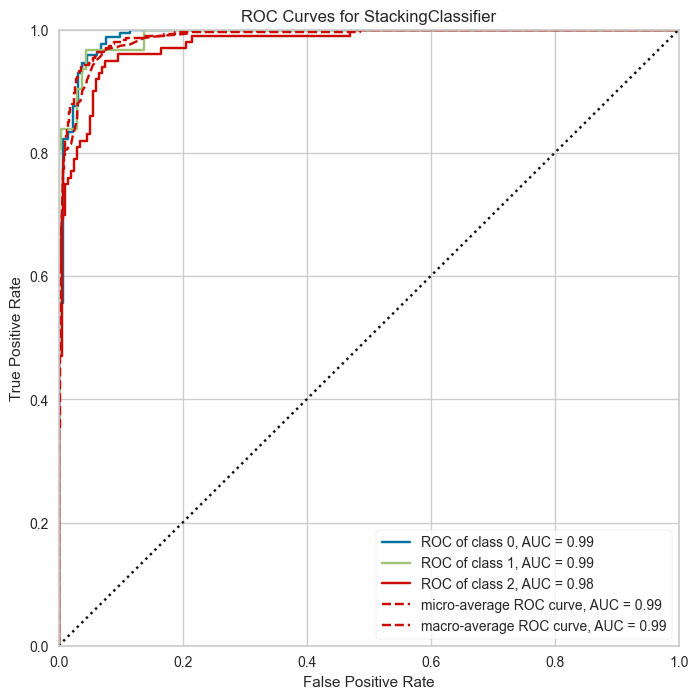

In [46]:
fig, ax = plt.subplots(figsize=(8, 8))
visualizer = ROCAUC(stacking_clf, classes=[0, 1, 2], ax=ax)

visualizer.fit(X_train_pre, y_train)
visualizer.score(X_test_pre, y_test)
visualizer.show();

Finalment, les corbes ROC corroboren l'excel·lent rendiment del **StackingClassifier**, totes les classes presenten valors d'**AUC** de 0.99, indicant una capacitat de discriminació quasi perfecta i confirmant que el model combina les prediccions dels estimadors base.

### Comparació amb models anteriors

In [47]:
results_df.sort_values(by=['test acc'], ascending=False)

,train XV acc,test acc,precision score (M),recall score (M),f1 score (M)
Stacking Classifier,0.912,0.933,0.935,0.907,0.919
linear SVM binary,0.906,0.923,0.903,0.906,0.904
Logistic Regression,0.897,0.907,0.893,0.870,0.880
Extra Trees,0.847,0.903,0.913,0.852,0.878
Gradient Boosting,0.867,0.900,0.888,0.864,0.874
GNB,0.522,0.507,0.603,0.638,0.539


El **Stacking Classifier** s'ha posicionat en primer lloc amb un **accuracy de test del 93.3%**, superant tots els altres models. A més, aconsegueix el **precision score** més alt (93.5%) i la màxima puntuació en totes les mètriques macro: **recall** del 90.7% i **f1-score** del 91.9%.

Observant la taula completa, destaca que els models lineals (**SVM** amb 92.3% i **LR** amb 90.7%) obtenen rendiments excel·lents, superiors als models d'ensemble no lineals (**GB** amb 90.0% i **ET** amb 90.3%). Aquest fet confirma que **les classes són linealment separables** en l'espai de característiques original, contràriament al que suggerien les visualitzacions inicials del PCA en 2D, que només capturen el 15% de la variància.

El **StackingClassifier**, combinant les fortaleses dels models lineals (SVM, LR) amb la capacitat d'**Extra Trees** per capturar interaccions no lineals, aconsegueix el millor rendiment global, demostrant que l'agregació d'estimadors complementaris millora la capacitat predictiva del sistema.

### Permutation Importance del Stacking Classifier

In [48]:
# Stacking Classifier
print("Top 15 Stacking Classifier\n")
stacking_perm_importance = permutation_importance(stacking_clf, X_test_pre, y_test, 
                                                   scoring='f1_macro', n_repeats=10, random_state=42)
stacking_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': stacking_perm_importance.importances_mean,
    'std': stacking_perm_importance.importances_std
}).sort_values('importance', ascending=False).head(15)

print(stacking_imp_df.to_string(index=False))

Top 15 Stacking Classifier

                    feature  importance   std
  cat__P14_4_Más perjuicios       0.027 0.003
                  num__P3_3       0.024 0.011
                 num__P13_3       0.023 0.015
                 num__P13_2       0.023 0.012
  cat__P14_4_Más beneficios       0.020 0.007
  cat__P14_7_Más perjuicios       0.016 0.007
                 num__P13_1       0.016 0.009
cat__P7_3_Bastante probable       0.015 0.009
  cat__P15_2_Más perjuicios       0.014 0.007
  cat__P15_3_Más perjuicios       0.014 0.009
  cat__P14_1_Más perjuicios       0.013 0.006
                  num__P3_5       0.012 0.009
  cat__P14_3_Más perjuicios       0.012 0.009
   cat__P11_3_Incertidumbre       0.011 0.008
  cat__P15_1_Más perjuicios       0.011 0.005


En el **Stacking Classifier**, observem novament que els atributs més importants provenen de `P14` i `P15` (percepcions sobre perjudicis de la IA). 

Cal destacar que en aquest model és el que **més pes dóna a atributs numèrics**, especialment a les diferents dimensions de la variable `P13` (que apareix 4 vegades en el TOP 15: `P13_3`, `P13_2`, `P13_1`), juntament amb `P3_3` i `P3_5`.

La metodologia d'aquest ensemble és distribuir la importància entre múltiples variables de forma equilibrada, creant diversos camins predictius complementaris i evitant que una sola variable predomini sobre les altres. Aquesta estratègia permet aprofitar la informació de diferents fonts de manera més robusta.

### Comparació d'atributs importants entre tots els models

Ara compararem els atributs més importants identificats pel **Stacking Classifier** amb els dels models anteriors (LR, SVM, GB, ET) per veure si hi ha semblança sobre quines variables són realment discriminatives.

In [53]:
# Obtenim els TOP 15 de cada model
stacking_top_features = set(stacking_imp_df['feature'].tolist())
gb_top_features = set(gb_imp_df['feature'].tolist())
et_top_features = set(et_imp_df['feature'].tolist())

# Per LR i SVM, agafem el TOP 15 de cada classe combinat
lr_top_features = set()
for cls in lr_top:
    lr_top_features.update(lr_top[cls]['feature'].head(15).tolist())

svm_top_features = set()
for cls in svm_top:
    svm_top_features.update(svm_top[cls]['feature'].head(15).tolist())

# Variables que apareixen en tots els models
all_models = stacking_top_features.intersection(gb_top_features, et_top_features, lr_top_features, svm_top_features)

# Variables que apareixen en almenys 4 dels 5 models
models_list = [stacking_top_features, gb_top_features, et_top_features, lr_top_features, svm_top_features]
from collections import Counter
all_features = []
for features_set in models_list:
    all_features.extend(list(features_set))

feature_counts = Counter(all_features)
features_in_4_plus = {feat for feat, count in feature_counts.items() if count >= 4}
features_in_3_plus = {feat for feat, count in feature_counts.items() if count >= 3}


print("Atributs en tots el models:")
if all_models:
    for feat in sorted(all_models):
        print(f"  - {feat}")


print(f"Atributs en almenys 4 dels 5 models:")
for feat in sorted(features_in_4_plus):
    count = feature_counts[feat]
    if count == 4:
        print(f"  - {feat}")


print(f"Atributs en almenys 3 dels 5 models:")
for feat in sorted(features_in_3_plus):
    count = feature_counts[feat]
    if count == 3:
        print(f"  - {feat}")

Atributs en tots el models:
  - cat__P14_1_Más perjuicios
  - cat__P14_4_Más perjuicios
  - cat__P15_1_Más perjuicios
  - cat__P15_3_Más perjuicios
Atributs en almenys 4 dels 5 models:
  - cat__P11_3_Incertidumbre
  - cat__P15_4_Más perjuicios
  - num__P13_3
Atributs en almenys 3 dels 5 models:
  - cat__P10_No
  - cat__P14_1_Más beneficios
  - cat__P14_3_Más perjuicios
  - cat__P14_5_Más perjuicios
  - cat__P14_7_Más perjuicios
  - cat__P15_4_Más beneficios
  - num__P13_2


Els resultats mostren un **fort consens** entre tots els models sobre quines variables són més discriminatives (ja que estan en tots 5 models):
- `cat__P14_1_Más perjuicios`
- `cat__P14_4_Más perjuicios`
- `cat__P15_1_Más perjuicios`
- `cat__P15_3_Más perjuicios`

Aquestes quatre variables, totes relacionades amb les **percepcions de perjudicis de la IA**, apareixen consistentment en tots els models (lineals i no lineals), confirmant que són els factors més discriminants per a la classificació.

Atributs en almenys 4 models:
- `cat__P11_3_Incertidumbre` (incertesa sobre la IA)
- `cat__P15_4_Más perjuicios` (més percepcions de perjudicis)
- `num__P13_3` (única variable numèrica amb presència consistent)

Atributs en almenys 3 models:
Variables addicionals inclouen `P10_No` (desconeixement), diverses dimensions de `P14` i `P15`, i `P13_2` (numèrica).

La majoria absoluta són **variables categòriques** relacionades amb opinions i percepcions. Les úniques variables numèriques amb pes significatiu són les dimensions de `P13`, confirmant que les opinions discretes tenen major poder predictiu que les variables continues en aquest problema.

## Conclusions finals

Com a conclusió d'aquest treball, inicialment la poca representativitat del **PCA en 2D** (només 15% de variància explicada) i els pobres resultats del **GNB** (52% accuracy) ens havien fet pensar que les classes no eren linealment separables, ja que obteníem resultats molt dolents amb aquest model generatiu.

Però, en entrenar models lineals discriminatius (**Logistic Regression** i **SVM**) que exploten millor la dimensionalitat completa de les variables i capturen millor les relacions entre elles, hem pogut afirmar que **les classes sí que són linealment separables** en l'espai original de característiques. Els models lineals han aconseguit **accuracy** superior al 90% (SVM: 92.3%, LR: 90.7%).

Els models no lineals (**Gradient Boosting**: 89.3%, **Extra Trees**: 90.3%) no han estat capaços d'estar a l'altura dels models lineals, cosa que reforça la hipòtesi de separabilitat lineal. Aquest fet podria deure's al fet que la complexitat addicional dels models no lineals no aporta valor quan les classes ja són linealment separables, o bé que podrien necessitar un ajust més fi dels hiperparàmetres.

Finalment, l'**StackingClassifier** (93.3% accuracy) ha demostrat que combinar els tres millors models (SVM, LR i ET) proporciona una millora significativa. Aquest ensemble aprofita les fortaleses complementàries de cadascun: la precisió del SVM en trobar fronteres lineals òptimes, l'estabilitat probabilística de la Regressió Logística, i la capacitat d'Extra Trees per capturar interaccions subtils entre variables.

Respecte als atributs més rellevants, tots els models coincideixen que les **percepcions sobre perjudicis de la IA** (variables `P14` i `P15`) són els factors més discriminants, juntament amb el **coneixement i la incertesa** sobre la IA (`P10`, `P11`) i algunes dimensions numèriques de `P13`.

Seria interessant també, per veure si canvien els resultats, aplicar **SMOTE** per reduir el desbalanceig de classes, ja que clarament la 0 era la dominant, i la 2 la marginada (amb poc més del 10%), tot i que els resultats ja mostren que aquesta classe té un recall de 93%, que ens indica que el desbalanceig no ha estat un problema. Potser en aplicar SMOTE, en estar balancejades, els models s'haurien comportat de manera diferent i s'hauria de mirar si milloren els resultats o els empitjoren.